In [4]:
import pygsti
import numpy as np
from scipy.linalg import expm
from pygsti.circuits import Circuit
from matplotlib import pyplot as plt
from pygsti.processors import QuditProcessorSpec

# target model def

In [5]:
# Gell-Mann matrices
gellmann_matrices = [
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]),
    np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]]),
    np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]),
    np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]]),
    np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]]),
    np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]]),
    np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]]),
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]])
]

gellmann_8_12 = np.array([[-2, 0, 0], [0, 1, 0], [0, 0, 1]])

In [190]:
# unitary models 
# we ignore axis error 
def modelX01(theta, gamma):
    return expm(-(1j/2)*((np.pi/2 + theta)*gellmann_matrices[1] + gamma*gellmann_matrices[8]))

def modelZ01():
    return expm(-(1j*np.pi/4)*gellmann_matrices[3])

Z12_gen = np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]])

def modelZ12():
    return expm(-(1j*np.pi/4)*Z12_gen)

X12_gen = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

def modelX12(theta):
    return expm(-(1j/2)*((np.pi/2 + theta)*X12_gen))

def modelCZ(phis):
    return np.diag([1]+[np.exp(-1j*phi) for phi in phis])



In [191]:
rho0vec = np.asarray([1, 0, 0])
rho00= np.kron(rho0vec, rho0vec)

E0vec = np.asarray([1, 0, 0])
E1vec = np.asarray([0, 1, 0])
E2vec = np.asarray([0, 0, 1])

E00 = np.kron(E0vec, E0vec)
E01 = np.kron(E0vec, E1vec)
E02 = np.kron(E0vec, E2vec)
E10 = np.kron(E1vec, E0vec)
E11 = np.kron(E1vec, E1vec)
E12 = np.kron(E1vec, E2vec)
E20 = np.kron(E2vec, E0vec)
E21 = np.kron(E2vec, E1vec)
E22 = np.kron(E2vec, E2vec)

povm_dict = {'00' : E00, '01' : E01, '02' : E02, '10' : E10, '11' : E11, '12' : E12, '20' : E20, '21' : E21, '22' : E22}

phis_target = np.array([0, 0, 0, -2*np.pi/3, -4*np.pi/3, 0, -2*np.pi/3, -4*np.pi/3])
gate_names = ['Gx_01_Q1', 'Gx_12_Q1', 'Gz_01_Q1', 'Gz_12_Q1', 'Gx_01_Q2', 'Gx_12_Q2', 'Gz_01_Q2', 'Gz_12_Q2', 'Gcz']
target_unitary_mapping = {
    'Gx_01_Q1': modelX01(0,0), 
    'Gx_12_Q1': modelX12(0), 
    'Gz_01_Q1': modelZ01(), 
    'Gz_12_Q1': modelZ12(),
    'Gx_01_Q2': modelX01(0,0),
    'Gx_12_Q2': modelX12(0),
    'Gz_01_Q2': modelZ01(),
    'Gz_12_Q2': modelZ12(),
    'Gcz': modelCZ(phis_target)
}
availability = {
    'Gx_01_Q1': [('Q1', )], 
    'Gx_12_Q1': [('Q1', )], 
    'Gz_01_Q1': [('Q1', )], 
    'Gz_12_Q1': [('Q1', )], 
    'Gx_01_Q2': [('Q2', )], 
    'Gx_12_Q2': [('Q2', )], 
    'Gz_01_Q2': [('Q2', )], 
    'Gz_12_Q2': [('Q2', )], 
    'Gcz': [('Q1', 'Q2')]
}



pspec = QuditProcessorSpec(['Q1', 'Q2'], qudit_udims=[3, 3], gate_names=gate_names,
                    nonstd_gate_unitaries=target_unitary_mapping,
                    prep_names = ['rho0'], povm_names = ['Mdefault'], 
                    nonstd_preps = {'rho0': rho00}, nonstd_povms = {'Mdefault': povm_dict}, 
                    availability=availability
                    )

In [192]:
target_model = pygsti.models.modelconstruction.create_explicit_model(pspec, 
                                                              ideal_gate_type='full TP', 
                                                              ideal_spam_type='full pure', 
                                                              basis='gm')

# Circuit construction

In [193]:
prep_dict = {
    '00' : ([]), 
}

meas_dict = {
    '00' : ([]),
}

gate_dict = {
    'G_CZ' : ([('Gcz', 'Q1', 'Q2')]),
    'G_X01' : ([('G_X01(Q1)', 'Q1')]),
    'G_Z01' : ([('G_Z01(Q1)', 'Q1')]),
    'G_X12' : ([('G_X12(Q1)', 'Q1')]),
    'G_Z12' : ([('G_Z12(Q1)', 'Q1')]),
    'G_X01' : ([('G_X01(Q2)', 'Q2')]),
    'G_Z01' : ([('G_Z01(Q2)', 'Q2')]),
    'G_X12' : ([('G_X12(Q2)', 'Q2')]),
    'G_Z12' : ([('G_Z12(Q2)', 'Q2')]),
}

def make_circuit(gate, prep_label, meas_label, depth):
    prep_circ = prep_dict[prep_label]
    meas_circ = meas_dict[meas_label]
    return Circuit(['rho0'] + prep_circ + [gate]*depth + meas_circ + ['Mdefault'], line_labels=['Q1', 'Q2'])

In [194]:
# simulate a circuit under the target model 

circ = make_circuit(('Gx_01_Q2', 'Q2'), '00', '00', 3)
print(circ)

target_model.probabilities(circ)

Qubit Q1 ---|rho0|-|        |-|        |-|        |-|Mdefault|---
Qubit Q2 ---|rho0|-|Gx_01_Q2|-|Gx_01_Q2|-|Gx_01_Q2|-|Mdefault|---



OutcomeLabelDict([(('00',), 0.4999999999999994),
                  (('01',), 0.4999999999999997),
                  (('02',), -2.463307335887066e-16),
                  (('10',), -1.3010426069826053e-16),
                  (('11',), -3.642919299551295e-17),
                  (('12',), -3.0704605524789486e-16),
                  (('20',), -1.474514954580286e-16),
                  (('21',), -1.6132928326584306e-16),
                  (('22',), -2.0816681711721685e-16)])

# Error model definitions

In [195]:
def parse_error_vector(x):
    info = {
        'single_qutrit': {
            'Q1': {
                'X01' : x[0],
                'phase': x[1],
                'X12' : x[2], 
            },
            'Q2': {
                'X01' : x[3],
                'phase': x[4],
                'X12' : x[5],
            }
        },
        'two_qutrit': {
            'phi1': x[6],
            'phi2': x[7],
            'phi3': x[8],
            'phi4': x[9],
            'phi5': x[10],
            'phi6': x[11],
            'phi7': x[12],
            'phi8': x[13]
        }  
    }
    return info

def random_error_vector(single_qutrit_rates, two_qutrit_rates):
    q1_vec = np.random.multivariate_normal(np.zeros(3), np.eye(3)*single_qutrit_rates)
    q2_vec = np.random.multivariate_normal(np.zeros(3), np.eye(3)*single_qutrit_rates)
    two_qubit_vec = np.random.multivariate_normal(np.zeros(8), np.eye(8)*two_qutrit_rates)
    return np.concatenate((q1_vec, q2_vec, two_qubit_vec))


In [196]:
from pygsti.tools import unitary_to_std_process_mx
from pygsti.modelmembers.operations import EmbeddedOp, FullArbitraryOp

In [197]:
from pygsti.baseobjs import ExplicitStateSpace
from pygsti.models import ExplicitOpModel
from pygsti.models.modelconstruction import create_spam_vector
from pygsti.modelmembers.povms import UnconstrainedPOVM, FullPOVMEffect
from pygsti.modelmembers.states import FullState
from pygsti.tools import change_basis
from pygsti.baseobjs import Basis


def make_model(error_vector, single_qutrit_depol, two_qutrit_depol):
    
    # Parse error vector
    errors = parse_error_vector(error_vector)
    x01_Q1 = errors['single_qutrit']['Q1']['X01']
    x12_Q1 = errors['single_qutrit']['Q1']['X12']
    x01_Q2 = errors['single_qutrit']['Q2']['X01']
    x12_Q2 = errors['single_qutrit']['Q2']['X12']
    
    phase_Q1 = errors['single_qutrit']['Q1']['phase']
    phase_Q2 = errors['single_qutrit']['Q2']['phase']

    phi1 = errors['two_qutrit']['phi1']
    phi2 = errors['two_qutrit']['phi2']
    phi3 = errors['two_qutrit']['phi3']
    phi4 = errors['two_qutrit']['phi4']
    phi5 = errors['two_qutrit']['phi5']
    phi6 = errors['two_qutrit']['phi6']
    phi7 = errors['two_qutrit']['phi7']
    phi8 = errors['two_qutrit']['phi8']
    phis = [phi1, phi2, phi3, phi4, phi5, phi6, phi7, phi8]

    # Define single qutrit unitaries
    X01_Q1_unitary = modelX01(x01_Q1, phase_Q1)
    Z01_Q1_unitary = modelZ01()
    X12_Q1_unitary = modelX12(x12_Q1)
    Z12_Q1_unitary = modelZ12()

    X01_Q2_unitary = modelX01(x01_Q2, phase_Q2)
    Z01_Q2_unitary = modelZ01()
    X12_Q2_unitary = modelX12(x12_Q2)
    Z12_Q2_unitary = modelZ12()

    # Define two qutrit unitary
    CZ_unitary = modelCZ(phis)

    target_unitary_mapping = {
        'Gx_01_Q1': X01_Q1_unitary,
        'Gx_12_Q1': X12_Q1_unitary,
        'Gz_01_Q1': Z01_Q1_unitary,
        'Gz_12_Q1': Z12_Q1_unitary,
        'Gx_01_Q2': X01_Q2_unitary,
        'Gx_12_Q2': X12_Q2_unitary,
        'Gz_01_Q2': Z01_Q2_unitary,
        'Gz_12_Q2': Z12_Q2_unitary,
        'Gcz': CZ_unitary
    }

    rho0vec = np.asarray([1, 0, 0])
    rho00= np.kron(rho0vec, rho0vec)

    E0vec = np.asarray([1, 0, 0])
    E1vec = np.asarray([0, 1, 0])
    E2vec = np.asarray([0, 0, 1])

    E00 = np.kron(E0vec, E0vec)
    E01 = np.kron(E0vec, E1vec)
    E02 = np.kron(E0vec, E2vec)
    E10 = np.kron(E1vec, E0vec)
    E11 = np.kron(E1vec, E1vec)
    E12 = np.kron(E1vec, E2vec)
    E20 = np.kron(E2vec, E0vec)
    E21 = np.kron(E2vec, E1vec)
    E22 = np.kron(E2vec, E2vec)

    povm_dict = {'00' : E00, '01' : E01, '02' : E02, '10' : E10, '11' : E11, '12' : E12, '20' : E20, '21' : E21, '22' : E22}

    phis_target = np.array([0, 0, 0, -2*np.pi/3, -4*np.pi/3, 0, -2*np.pi/3, -4*np.pi/3])
    gate_names = ['Gx_01_Q1', 'Gx_12_Q1', 'Gz_01_Q1', 'Gz_12_Q1', 'Gx_01_Q2', 'Gx_12_Q2', 'Gz_01_Q2', 'Gz_12_Q2', 'Gcz']
    availability = {
        'Gx_01_Q1': [('Q1', )], 
        'Gx_12_Q1': [('Q1', )], 
        'Gz_01_Q1': [('Q1', )], 
        'Gz_12_Q1': [('Q1', )], 
        'Gx_01_Q2': [('Q2', )], 
        'Gx_12_Q2': [('Q2', )], 
        'Gz_01_Q2': [('Q2', )], 
        'Gz_12_Q2': [('Q2', )], 
        'Gcz': [('Q1', 'Q2')]
    }

    # define the processor spec
    pspec = QuditProcessorSpec(['Q1', 'Q2'], qudit_udims=[3, 3], gate_names=gate_names,
                    nonstd_gate_unitaries=target_unitary_mapping,
                    prep_names = ['rho0'], povm_names = ['Mdefault'],
                    nonstd_preps = {'rho0': rho00}, nonstd_povms = {'Mdefault': povm_dict},
                    availability=availability
                    )
    model = pygsti.models.modelconstruction.create_explicit_model(pspec,ideal_gate_type='full TP', ideal_spam_type='full pure', basis='gm')

    # add depolarizing noise
    model.operations[('Gx_01_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gz_01_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gx_12_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gz_12_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gx_01_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gz_01_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gx_12_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gz_12_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gcz', 'Q1', 'Q2')].depolarize(two_qutrit_depol)

    return model


    # # Define single qutrit gates
    # X01_Q1_unitary = unitary_to_std_process_mx(modelX01(x01_Q1, phase01_Q1))
    # Z01_Q1_unitary = unitary_to_std_process_mx(modelZ01())
    # X12_Q1_unitary = unitary_to_std_process_mx(modelX12(x12_Q1, phase12_Q1))
    # Z12_Q1_unitary = unitary_to_std_process_mx(modelZ12())

    # X01_Q1_gate = FullArbitraryOp(X01_Q1_unitary, evotype='densitymx', basis='gm')
    # Z01_Q1_gate = FullArbitraryOp(Z01_Q1_unitary, evotype='densitymx', basis='gm')
    # X12_Q1_gate = FullArbitraryOp(X12_Q1_unitary, evotype='densitymx', basis='gm')
    # Z12_Q1_gate = FullArbitraryOp(Z12_Q1_unitary, evotype='densitymx', basis='gm')

    # X01_Q1_gate.depolarize(single_qutrit_depol)
    # Z01_Q1_gate.depolarize(single_qutrit_depol)
    # X12_Q1_gate.depolarize(single_qutrit_depol)
    # Z12_Q1_gate.depolarize(single_qutrit_depol)

    # X01_Q2_unitary = unitary_to_std_process_mx(modelX01(x01_Q2, phase01_Q2))
    # Z01_Q2_unitary = unitary_to_std_process_mx(modelZ01())
    # X12_Q2_unitary = unitary_to_std_process_mx(modelX12(x12_Q2, phase12_Q2))
    # Z12_Q2_unitary = unitary_to_std_process_mx(modelZ12())


    # X01_Q2_gate = FullArbitraryOp(X01_Q1_unitary, evotype='densitymx', basis='gm')
    # Z01_Q2_gate = FullArbitraryOp(Z01_Q1_unitary, evotype='densitymx', basis='gm')
    # X12_Q2_gate = FullArbitraryOp(X12_Q1_unitary, evotype='densitymx', basis='gm')
    # Z12_Q2_gate = FullArbitraryOp(Z12_Q1_unitary, evotype='densitymx', basis='gm')
                               
    # X01_Q2_gate.depolarize(single_qutrit_depol)
    # Z01_Q2_gate.depolarize(single_qutrit_depol)
    # X12_Q2_gate.depolarize(single_qutrit_depol)
    # Z12_Q2_gate.depolarize(single_qutrit_depol)

    # # Define two qutrit gates
    # CZ_unitary = unitary_to_std_process_mx(modelCZ(phis))
    # CZ_mat = change_basis(CZ_unitary, 'std', 'gm')
    # CZ = FullArbitraryOp(CZ_mat, evotype='densitymx', basis='gm')
    # CZ.depolarize(two_qutrit_depol)

    # # Add gates to model
    # joint_state_space = model.state_space
    # model.operations[('Gx_01', 'Q1')] = X01_Q1_gate
    # model.operations[('Gz_01', 'Q1')] = Z01_Q1_gate
    # model.operations[('Gx_12', 'Q1')] = X12_Q1_gate
    # model.operations[('Gz_12', 'Q1')] = Z12_Q1_gate
    # model.operations[('Gx_01', 'Q2')] = X01_Q2_gate
    # model.operations[('Gz_01', 'Q2')] = Z01_Q2_gate
    # model.operations[('Gx_12', 'Q2')] = X12_Q2_gate
    # model.operations[('Gz_12', 'Q2')] = Z12_Q2_gate

    # model.operations['Gcz'] = CZ

    # return model

In [198]:
def plot_outcome_dist_2qt(outcomes, target=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # keys a
    keys = ['00', '01', '02', '10', '11', '12', '20', '21', '22']
    vals = np.zeros(9)
    if target is not None:
        tag_vals = np.zeros(9)
        for idx, key in enumerate(keys):
            if key in target:
                tag_vals[idx] = target[key]
    for idx, key in enumerate(keys):
        if key in outcomes:
            vals[idx] = outcomes[key]
    if target is None:
        ax.bar(keys, vals)
    else:
        ax.bar(keys, vals, label='Simulated', alpha=0.5)
        ax.bar(keys, tag_vals, label='Target', alpha=0.5)
        ax.legend()

Qubit Q1 ---|rho0|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Mdefault|---
Qubit Q2 ---|rho0|-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|Mdefault|---

OutcomeLabelDict([(('00',), 0.08533447295951187), (('01',), 0.07624326710111078), (('02',), 0.07624326710111079), (('10',), 0.3809626573327093), (('11',), 0.07624326710111082), (('12',), 0.0762432671011108), (('20',), 0.07624326710111083), (('21',), 0.07624326710111078), (('22',), 0.07624326710111082)])


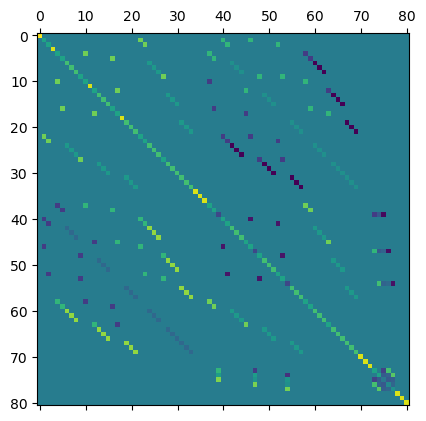

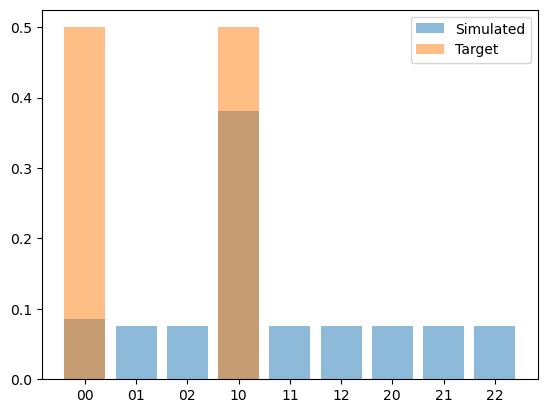

In [199]:
x = random_error_vector(0.1, 0.1)
model = make_model(x, 0.1, 0.1)
plt.matshow(model[(('Gx_01_Q1', 'Q1'))].to_dense().real)
circ = make_circuit(('Gx_01_Q1', 'Q1'), '00', '00', 11)
print(circ)
probs = model.probabilities(circ)
target_probs = target_model.probabilities(circ)
print(probs)
plot_outcome_dist_2qt(probs, target_probs)

# Single qutrit RPE

In [307]:
phase_sin_prep_fiducial =   Gz01 @ Gz01 @ Gz01 @Gx01 @ Gz01 @ Gx12 @ (Gx01 @ Gx01)

phase_cos_prep_fiducial =   Gz01 @ Gz01 @ Gz01 @ Gz01 @ Gx01 @ Gz01 @ Gx12 @ (Gx01 @ Gx01)

In [243]:
fiducial_prep_dict = {
    'id' : [],
    'X01_Q1_cos_prep': [], 
    'X01_Q1_sin_prep': [], 
    'X12_Q1_cos_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'X12_Q1_sin_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'phase_Q1_cos_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1')],
    'phase_Q1_sin_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1')],
}

fiducial_meas_dict = {
    'id' : [],
    'X01_Q1_cos_meas': [], 
    'X01_Q1_sin_meas': [('Gx_01_Q1', 'Q1'),],
    'X12_Q1_cos_meas': [],
    'X12_Q1_sin_meas': [('Gx_12_Q1', 'Q1'),],
    'phase_Q1_cos_meas': [('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'),
                          ('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), 
                          ('Gz_01_Q1', 'Q1'),
                          ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'),
                          ('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'phase_Q1_sin_meas': [('Gz_01_Q1', 'Q1'),
                          ('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'),
                          ('Gx_12_Q1', 'Q1')],
}

## Verify phase fiducials


In [303]:
Gx01 = target_model.operations[('Gx_01_Q1', 'Q1')].to_dense()
Gz01 = target_model.operations[('Gz_01_Q1', 'Q1')].to_dense()
Gx12 = target_model.operations[('Gx_12_Q1', 'Q1')].to_dense()
Gz12 = target_model.operations[('Gz_12_Q1', 'Q1')].to_dense()

phase_sin_prep_fiducial =   Gz01 @ Gz01 @ Gz01 @Gx01 @ Gz01 @ Gx12 @ (Gx01 @ Gx01)
phase_cos_prep_fiducial =   Gz01 @ Gz01 @ Gz01 @ Gz01 @Gx01 @ Gz01 @ Gx12 @ (Gx01 @ Gx01)
rho0 = np.diag([1, 0, 0, 0, 0, 0, 0, 0, 0]).flatten()
phase_cos_meas_fiducial_std = change_basis(phase_cos_prep_fiducial, 'gm', 'std')
rho =  phase_cos_meas_fiducial_std @ rho0 
rho_mat = rho.reshape((9, 9))


(0.9999999999999969+0j)


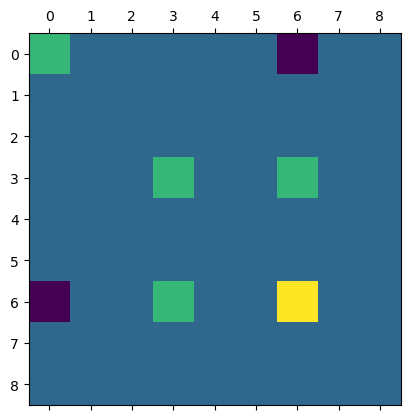

In [304]:
plt.matshow(rho_mat.real)
print(np.trace(rho_mat))

In [305]:
# get the eigenvector corresponding to the largest eigenvalue and normalize it
eigvals, eigvecs = np.linalg.eig(rho_mat)
max_eigval_idx = np.argmax(eigvals)
max_eigvec = eigvecs[:, max_eigval_idx]
max_eigvec = max_eigvec / np.linalg.norm(max_eigvec)
print(max(eigvals))
np.round(max_eigvec, 3)

(0.9999999999999993-4.400379414708702e-33j)


array([-0.354-0.354j, -0.   -0.j   ,  0.   +0.j   ,  0.354-0.354j,
        0.   +0.j   ,  0.   +0.j   ,  0.707+0.j   ,  0.   +0.j   ,
        0.   +0.j   ])

In [306]:
nu = np.array([1/2, 1/2, 1/np.sqrt(2)])
psi0 = np.array([1, 0, 0])
print(np.kron(nu, psi0))

[0.5        0.         0.         0.5        0.         0.
 0.70710678 0.         0.        ]


In [247]:
def make_rpe_circuit(gate, prep_label, meas_label, depth):
    prep_circ = fiducial_prep_dict[prep_label]
    meas_circ = fiducial_meas_dict[meas_label]
    return Circuit(['rho0'] + prep_circ + [gate]*depth + meas_circ + ['Mdefault'], line_labels=['Q1', 'Q2'])

In [248]:
print(make_rpe_circuit([], 'phase_Q1_cos_prep', 'id', 1))
print(make_rpe_circuit([], 'phase_Q1_sin_prep', 'id', 1))
print(make_rpe_circuit([], 'id', 'phase_Q1_cos_meas', 1))
print(make_rpe_circuit([], 'id', 'phase_Q1_sin_meas', 1))

Qubit Q1 ---|rho0|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_12_Q1|-|Gz_01_Q1|-|Gx_01_Q1|-|Gz_01_Q1|-|Gz_01_Q1|-|Gz_01_Q1|-| |-|Mdefault|---
Qubit Q2 ---|rho0|-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-| |-|Mdefault|---

Qubit Q1 ---|rho0|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_12_Q1|-|Gz_01_Q1|-|Gx_01_Q1|-|Gz_01_Q1|-|Gz_01_Q1|-|Gz_01_Q1|-| |-|Mdefault|---
Qubit Q2 ---|rho0|-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-| |-|Mdefault|---

Qubit Q1 ---|rho0|-| |-|Gz_01_Q1|-|Gz_01_Q1|-|Gz_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_12_Q1|-|Gz_01_Q1|-|Gx_12_Q1|-|Gx_12_Q1|-|Gx_12_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Mdefault|---
Qubit Q2 ---|rho0|-| |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|Mdefault|---

Qubit Q1 ---|rho0|-| |-|Gz_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_12_Q1|-|Gx_12_Q1|-|Mdefault|---
Qubit Q2 ---|rho0|-| |-|        |-|        |-|        |-|        |-

In [249]:
def make_single_qutrit_rpe_edesign_Q1(depths):
    circuits = {
        'X01' : {'cos': [], 'sin': []},
        'X01' : {'cos': [], 'sin': []},
        'X12' : {'cos': [], 'sin': []},
        'X12' : {'cos': [], 'sin': []},
        'phase' : {'cos': [], 'sin': []},
        'phase' : {'cos': [], 'sin': []},
    }
    for depth in depths:
        circuits['X01']['cos'].append(make_rpe_circuit(('Gx_01_Q1', 'Q1'), 'X01_Q1_cos_prep', 'X01_Q1_cos_meas', depth))
        circuits['X01']['sin'].append(make_rpe_circuit(('Gx_01_Q1', 'Q1'), 'X01_Q1_sin_prep', 'X01_Q1_sin_meas', depth))
        circuits['X12']['cos'].append(make_rpe_circuit(('Gx_12_Q1', 'Q1'), 'X12_Q1_cos_prep', 'X12_Q1_cos_meas', depth))
        circuits['X12']['sin'].append(make_rpe_circuit(('Gx_12_Q1', 'Q1'), 'X12_Q1_sin_prep', 'X12_Q1_sin_meas', depth))
        circuits['phase']['cos'].append(make_rpe_circuit(('Gz_01_Q1', 'Q1'), 'phase_Q1_cos_prep', 'phase_Q1_cos_meas', depth))
        circuits['phase']['sin'].append(make_rpe_circuit(('Gz_01_Q1', 'Q1'), 'phase_Q1_sin_prep', 'phase_Q1_sin_meas', depth))
    return circuits
        
def edesign_to_circuit_list(edesign):
    circuits = []
    for etype in edesign.keys():
        for mtype in edesign[etype].keys():
            for circuit in edesign[etype][mtype]:
                circuits.append(circuit)
    return pygsti.tools.remove_duplicates(circuits)


In [250]:
import pygsti

In [251]:
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ

def estimate_phase_from_dataset(ds, cos_circs, cos_outcome0, cos_outcome1, sin_circs, sin_outcome0, sin_outcome1, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        if d == 0:
            continue
        experiment.process_cos(d, (int(ds[cos_circs[idx]].counts[cos_outcome0]), int(ds[cos_circs[idx]].counts[cos_outcome1])))
        experiment.process_sin(d, (int(ds[sin_circs[idx]].counts[sin_outcome0]), int(ds[sin_circs[idx]].counts[sin_outcome1])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

In [252]:
x = random_error_vector(0.01, 0.01)
model = make_model(x, 0.001, 0.001)
depths = [2**i for i in range(10)]
edesign = make_single_qutrit_rpe_edesign_Q1(depths)
circ_list = edesign_to_circuit_list(edesign)
ds = pygsti.data.simulate_data(model, circ_list, num_samples=1000, seed=2021)

In [253]:
def rectify_phase (phase):
    """for the interval [-pi, pi]"""
    return (phase + np.pi) % (2*np.pi) - np.pi

In [254]:
# x01 overrot
phase_estimates, lgg = estimate_phase_from_dataset(ds, edesign['X01']['cos'], '00', '10', edesign['X01']['sin'], '00', '10', depths)
last_good_x01_q1_phase = phase_estimates[lgg]
phase_error = -last_good_x01_q1_phase - np.pi/2
rectified_phase_error = rectify_phase(phase_error)
x01_q1_overrot_estimate = rectified_phase_error
print(rectified_phase_error, lgg)

-0.01715184128119862 9


In [255]:
# x12 overrot
phase_estimates, lgg = estimate_phase_from_dataset(ds, edesign['X12']['cos'], '10', '20', edesign['X12']['sin'], '10', '10', depths)
print(phase_estimates)
last_good_x01_q1_phase = phase_estimates[lgg]
phase_error = -last_good_x01_q1_phase - np.pi/2
rectified_phase_error = rectify_phase(phase_error)
x01_q1_overrot_estimate = rectified_phase_error
print(x01_q1_overrot_estimate, lgg)

/home/jpmarceaux/anaconda3/envs/ErrorGenerators/lib/python3.10/site-packages/quapack/pyRPE/quantum.py:46: RuntimeWarning: invalid value encountered in scalar divide
  Pp_Ns = Cp_Ns / (Cp_Ns + Cm_Ns)


AssertionError: 

In [256]:
# phase error
phase_estimates, lgg = estimate_phase_from_dataset(ds, edesign['phase']['cos'], '10', '01', edesign['phase']['sin'], '10', '01', depths)
last_good_phase_phase_raw = phase_estimates[lgg]
print(last_good_phase_phase_raw)
phase_gm_estimate_unrectified = (2*last_good_phase_phase_raw - last_good_x01_q1_phase)/3
phase_gm_estimate = rectify_phase(phase_gm_estimate_unrectified)
print(phase_gm_estimate, lgg)


0.001797788517709396
-1.57531508154349 9


In [257]:
x

array([-0.01723471, -0.05499879,  0.02845981, -0.20587493,  0.1267758 ,
        0.08571078, -0.07099828, -0.08803664, -0.01035797,  0.04813279,
        0.09994937,  0.0109915 ,  0.01920393, -0.06215557])

In [258]:
def plot_edesign_probability_from_model_and_target(edesign, depths, model, target_model):
    for etype in edesign.keys():
        fig, ax = plt.subplots(2, len(depths), figsize=(15, 10))
        for m_idx, mtype in enumerate(edesign[etype].keys()):
            for depth_idx, circuit in enumerate(edesign[etype][mtype]):
                probs = model.probabilities(circuit)
                target_probs = target_model.probabilities(circuit)
                plot_outcome_dist_2qt(probs, target_probs, ax[m_idx, depth_idx])
                ax[m_idx, depth_idx].set_title(f'{etype} {mtype} depth {depths[depth_idx]}')
        plt.tight_layout()
        plt.show()
        plt.figure()

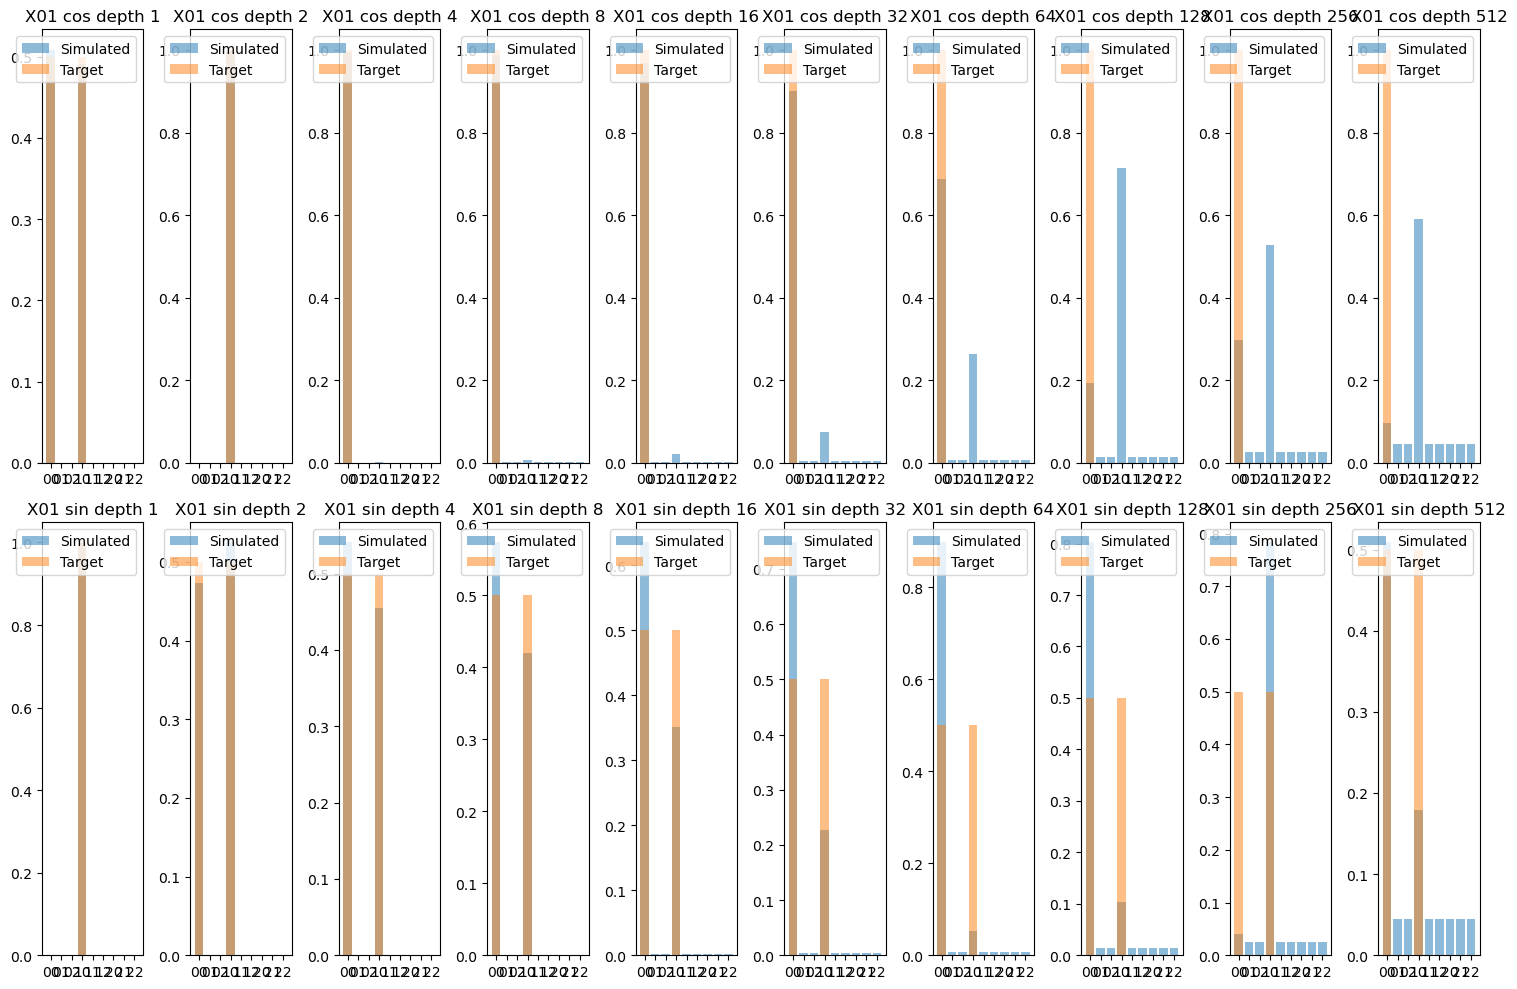

<Figure size 640x480 with 0 Axes>

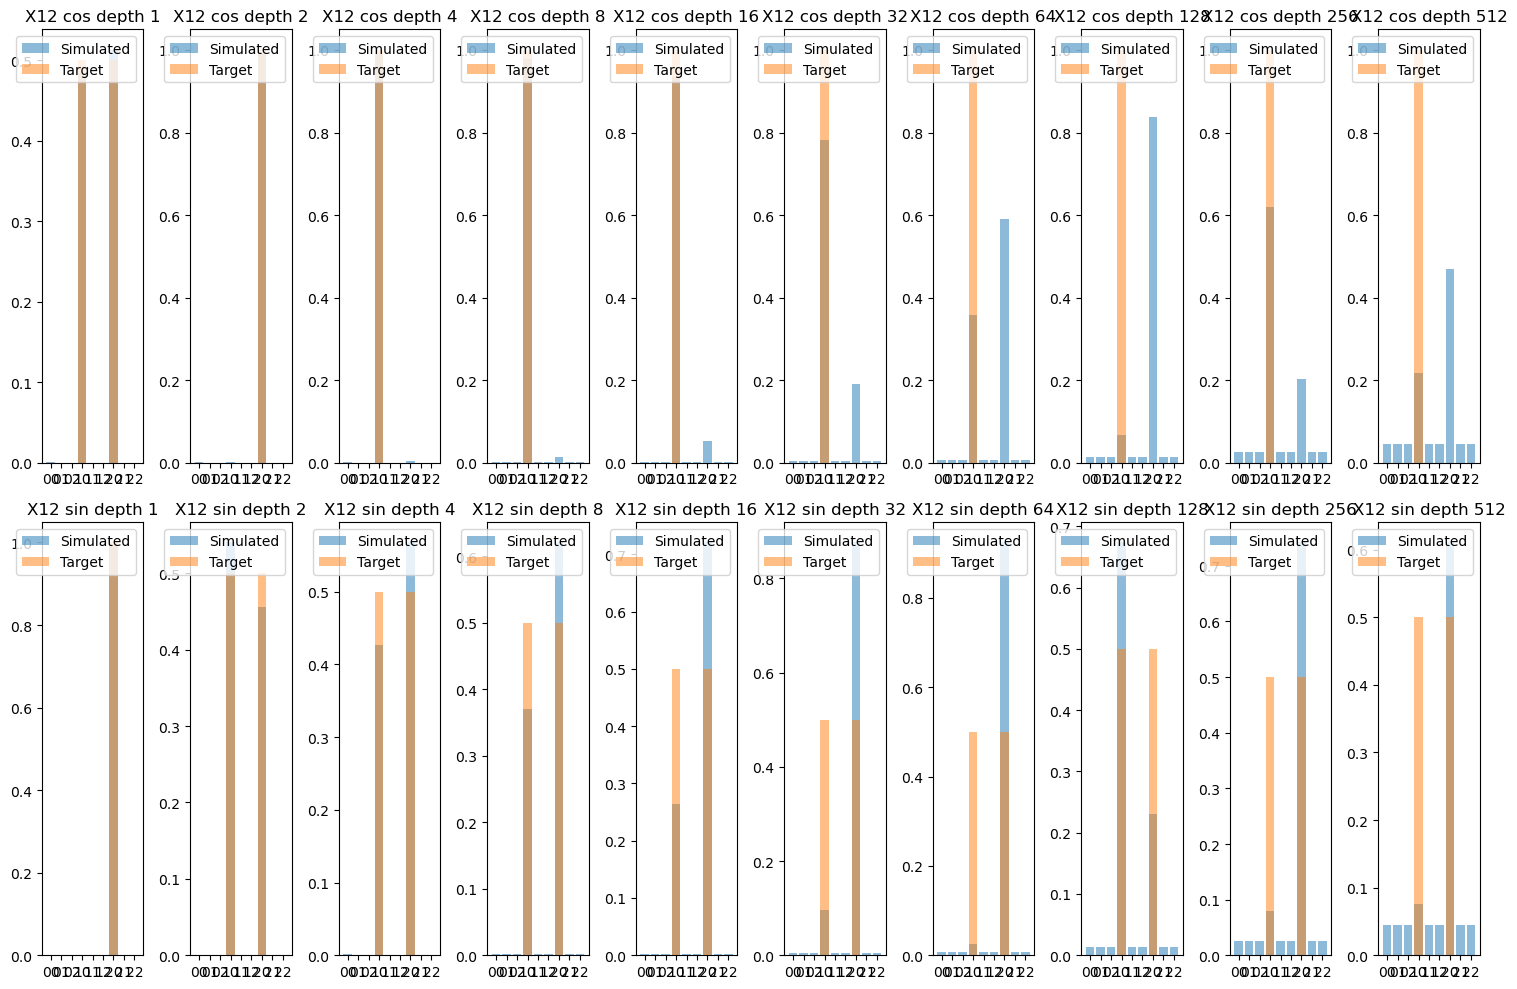

<Figure size 640x480 with 0 Axes>

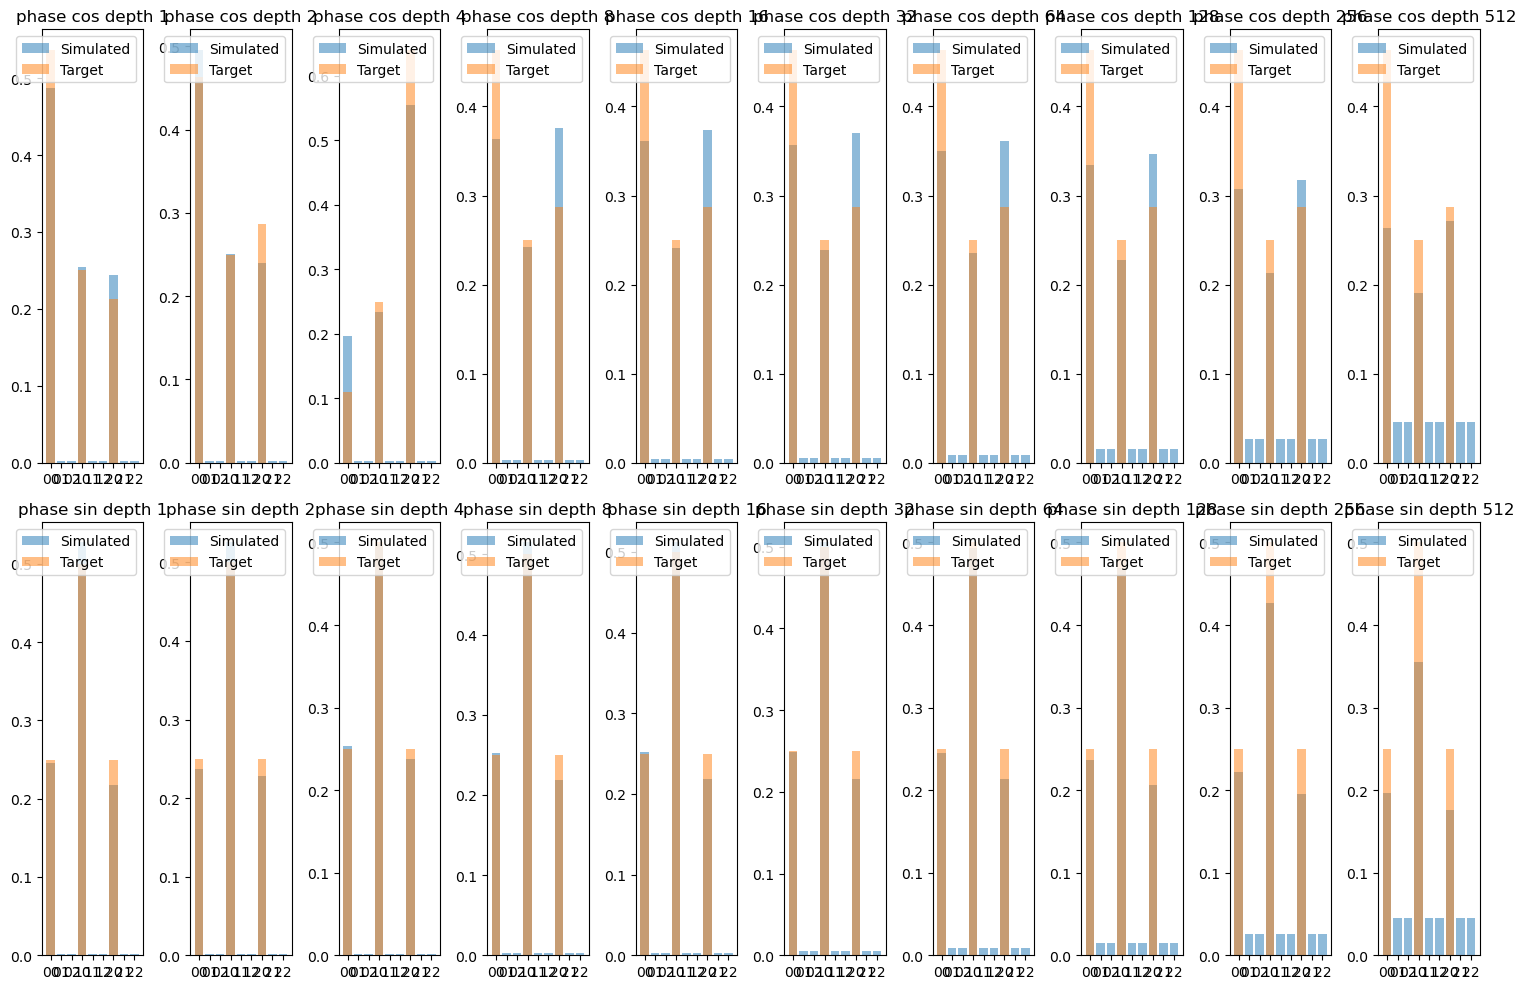

<Figure size 640x480 with 0 Axes>

In [259]:
plot_edesign_probability_from_model_and_target(edesign, depths, model, target_model)